## Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `figure2..` where the bottom part is from `8_canopy_cover_aspect` and the top is from `4_domain_plots.ipynb`
### Calculate the percent canopy cover for each BAF by aspect 

created by Cassie Lumbrazo\
last updated: July 2025\
run location: UAS Linux\
python environment: **cer_treatment**

In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

# import geopandas as gpd

import scipy

In [2]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

# ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_raster_analysis\\rapid_model_cleandata_create_netcdf_negtozero_v3_b.nc') 
ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine
ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 21kB 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 11kB 2.111e+05 ... 2.097e+05
  * band                              (band) int32 4B 1
    spatial_ref                       int32 4B ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 14MB ...
    dce_rapid                         (band, y, x) float32 14MB ...
    giulia_dce_rapid                  (band, y, x) float32 14MB ...
    giulia_dce_ncalm                  (band, y, x) float32 14MB ...
    slope                             (band, y, x) float32 14MB ...
    aspect                            (band, y, x) float32 14MB ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 14MB ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 14MB ...

In [4]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 21kB 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 11kB 2.111e+05 ... 2.097e+05
  * band                              (band) int32 4B 1
    spatial_ref                       int32 4B ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 14MB ...
    dce_rapid                         (band, y, x) float32 14MB ...
    giulia_dce_rapid                  (band, y, x) float32 14MB ...
    giulia_dce_ncalm                  (band, y, x) float32 14MB ...
    slope                             (band, y, x) float32 14MB ...
    aspect                            (band, y, x) float32 14MB ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 14MB ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 14MB ...

Define Constants

In [7]:
# because we are loading the simple dataset to save on memory, we need to calculate a few things...
# create binary object for dah
ds['dah_binary'] = np.nan
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] >= 0),  1)  # where DAH is greater than 0, then 1 for high heat index
ds['dah_binary'] = ds['dah_binary'].where(~(ds['dah'] <  0), -1)  # where DAH is less than or equal to 0, then -1 for low heat index

# and, make the baf_ridge binary 
ds['baf_ridge'] = ds['baf_ridge'].where(~(ds['baf_ridge'] >= 0),  1) # where not false (true) fill with 1 (south)
ds['baf_ridge'] = ds['baf_ridge'].where(~(ds['baf_ridge'] <  0), -1) # where not false (true) fill with -1 (north)

# ds['baf'] = ds['baf_new'].copy(deep=True)

In [8]:
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

So, we want to calculate the percentage of canopy cover like before in notebook `7_canopy_cover`\
except now we want to break this up by aspect (side of the ridge)\
So I made a copy of notebook 7 to just edit the code for aspect and replot everything. 

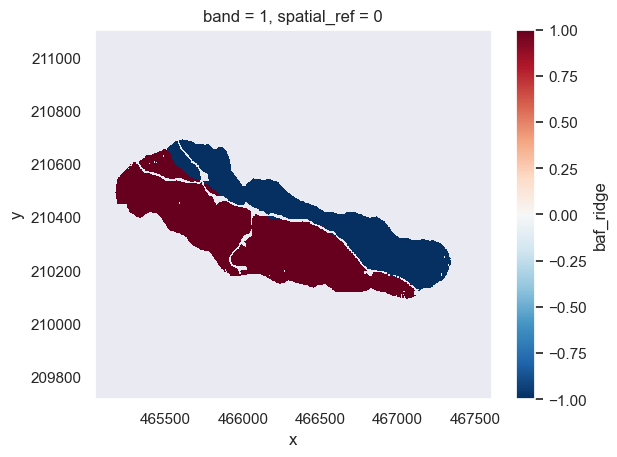

In [9]:
ds['baf_ridge'].plot()

### Calculate % Canopy Cover On Each Side of the Ridge

In [10]:
# create two versions of the dataframe, one for the north and one for the south
ds_north = ds.where(ds['baf_ridge'] == -1, drop=True)
ds_south = ds.where(ds['baf_ridge'] ==  1, drop=True)

In [13]:
# Initialize the DataFrame
df = pd.DataFrame(columns=['BAF', 'pre_north', 'pre_south', 'post_north', 'post_south'])
df['BAF'] = [1, 2, 17, 30, 32, 38, 60, 69, 80, 82, 90, 140, 150, 155]

# Loop through the BAF values and calculate the percentage of canopy cover
for index, row in df.iterrows():
    BAF = row['BAF']
    
    # Define the canopy cover threshold
    canopy_threshold = 3
    
    #_______________________________________________________________________________
    # PRE-TREATMENT
    # Determine the canopy grid cells
    canopy_mask = ds_north['chmws_ncalm'] > canopy_threshold

    # Calculate the total number of canopy grid cells in the forest treatment area
    treatment_area = ds_north['baf'].where(ds_north['baf'] == BAF)
    total_canopy_cells = np.sum(canopy_mask * treatment_area)

    # Calculate the total number of grid cells in the forest treatment area
    total_treatment_cells = np.sum(treatment_area)

    # Calculate the percentage of canopy cover
    percentage_canopy_cover = (total_canopy_cells / total_treatment_cells) * 100

    # Update the DataFrame with the percentage of canopy cover
    df.at[index, 'pre_north'] = percentage_canopy_cover.values.astype(int)
    
    #_______________________________________________________________________________
    # now, do the same thing for the south side 
    canopy_mask = ds_south['chmws_ncalm'] > canopy_threshold

    # Calculate the total number of canopy grid cells in the forest treatment area
    treatment_area = ds_south['baf'].where(ds_south['baf'] == BAF)
    total_canopy_cells = np.sum(canopy_mask * treatment_area)

    # Calculate the total number of grid cells in the forest treatment area
    total_treatment_cells = np.sum(treatment_area)

    # Calculate the percentage of canopy cover
    percentage_canopy_cover = (total_canopy_cells / total_treatment_cells) * 100

    # Update the DataFrame with the percentage of canopy cover
    df.at[index, 'pre_south'] = percentage_canopy_cover.values.astype(int)

    #_______________________________________________________________________________
    # POST-TREATMENT
    # Determine the canopy grid cells
    canopy_mask = ds_north['chmws_rapid'] > canopy_threshold

    # Calculate the total number of canopy grid cells in the forest treatment area
    treatment_area = ds_north['baf'].where(ds_north['baf'] == BAF)
    total_canopy_cells = np.sum(canopy_mask * treatment_area)

    # Calculate the total number of grid cells in the forest treatment area
    total_treatment_cells = np.sum(treatment_area)

    # Calculate the percentage of canopy cover
    percentage_canopy_cover = (total_canopy_cells / total_treatment_cells) * 100

    # Update the DataFrame with the percentage of canopy cover
    df.at[index, 'post_north'] = percentage_canopy_cover.values.astype(int)
    
    #_______________________________________________________________________________
    # now, do the same thing for the south side 
    canopy_mask = ds_south['chmws_rapid'] > canopy_threshold

    # Calculate the total number of canopy grid cells in the forest treatment area
    treatment_area = ds_south['baf'].where(ds_south['baf'] == BAF)
    total_canopy_cells = np.sum(canopy_mask * treatment_area)

    # Calculate the total number of grid cells in the forest treatment area
    total_treatment_cells = np.sum(treatment_area)

    # Calculate the percentage of canopy cover
    percentage_canopy_cover = (total_canopy_cells / total_treatment_cells) * 100

    # Update the DataFrame with the percentage of canopy cover
    df.at[index, 'post_south'] = percentage_canopy_cover.values.astype(int)

# Print the DataFrame
print(df)

/tmp/ipykernel_4018823/3789316599.py:28: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'pre_north'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:63: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'post_north'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:28: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'pre_north'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:63: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'post_north'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:45: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'pre_south'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:80: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'post_south'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykerne

    BAF             pre_north             pre_south            post_north  \
0     1                    34                     9                    64   
1     2  -9223372036854775808                    84  -9223372036854775808   
2    17                     9                    13                     9   
3    30  -9223372036854775808                    20  -9223372036854775808   
4    32                    83  -9223372036854775808                    53   
5    38                    87  -9223372036854775808                    42   
6    60                    68                    76                    49   
7    69                     0                    59                     0   
8    80  -9223372036854775808                    80  -9223372036854775808   
9    82                    79                   100                    62   
10   90  -9223372036854775808                    89  -9223372036854775808   
11  140                    49                    75                    61   

/tmp/ipykernel_4018823/3789316599.py:28: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'pre_north'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:63: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'post_north'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:28: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'pre_north'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:63: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'post_north'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:45: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'pre_south'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykernel_4018823/3789316599.py:80: RuntimeWarning: invalid value encountered in cast
  df.at[index, 'post_south'] = percentage_canopy_cover.values.astype(int)
/tmp/ipykerne

In [14]:
print(df)

    BAF             pre_north             pre_south            post_north  \
0     1                    34                     9                    64   
1     2  -9223372036854775808                    84  -9223372036854775808   
2    17                     9                    13                     9   
3    30  -9223372036854775808                    20  -9223372036854775808   
4    32                    83  -9223372036854775808                    53   
5    38                    87  -9223372036854775808                    42   
6    60                    68                    76                    49   
7    69                     0                    59                     0   
8    80  -9223372036854775808                    80  -9223372036854775808   
9    82                    79                   100                    62   
10   90  -9223372036854775808                    89  -9223372036854775808   
11  140                    49                    75                    61   

In [15]:
# cleaning up a few things
df = df.astype(int)

# drop any values < 0, and make nan 
df = df.where(df > 0)

# change the value of df['baf'] 1 to 'leave gap' and 2 to 'leave forest'
#df['BAF'] = df['BAF'].replace({1: 'leave gap', 2: 'leave forest', 17: 'BAF 17', 30: 'BAF 30', 32: 'BAF 32', 38: 'BAF 38', 
#                                       60: 'BAF 60', 69: 'BAF 69', 80: 'BAF 80', 82: 'BAF 82', 90: 'BAF 90', 140: 'BAF 140', 150: 'BAF 150', 155: 'BAF 155'})

df['BAF'] = df['BAF'].replace({1: 'leave gap', 2: 'leave forest', 17: 'BA 17', 30: 'BA 30', 32: 'BA 32', 38: 'BA 38', 
                                       60: 'BA 60', 69: 'BA 69', 80: 'BA 80', 82: 'BA 82', 90: 'BA 90', 140: 'BA 140', 150: 'BA 150', 155: 'BA 155'})

# move the leave forest to the last place in the dataframe
df = df.reindex([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1])

df.head()

,BAF,pre_north,pre_south,post_north,post_south
0,leave gap,34.0,9.0,64.0,15.0
2,BA 17,9.0,13.0,9.0,24.0
3,BA 30,NaN,20.0,NaN,30.0
4,BA 32,83.0,NaN,53.0,NaN
5,BA 38,87.0,NaN,42.0,NaN


In [16]:
df

,BAF,pre_north,pre_south,post_north,post_south
0,leave gap,34.0,9.0,64.0,15.0
2,BA 17,9.0,13.0,9.0,24.0
3,BA 30,NaN,20.0,NaN,30.0
4,BA 32,83.0,NaN,53.0,NaN
5,BA 38,87.0,NaN,42.0,NaN
6,BA 60,68.0,76.0,49.0,41.0
7,BA 69,NaN,59.0,NaN,53.0
8,BA 80,NaN,80.0,NaN,47.0
9,BA 82,79.0,100.0,62.0,100.0
10,BA 90,NaN,89.0,NaN,56.0


But we really need this dataframe is a different structure to plot it...

In [17]:
df['pre_north'] = df['pre_north'].where(df['BAF'] != 'BA 17', np.nan) # there should not be values for 17 on north
df['post_north'] = df['post_north'].where(df['BAF'] != 'BA 17', np.nan)

df['pre_south'] = df['pre_south'].where(df['BAF'] != 'BA 82', np.nan) # there should not be values for 82 on south
df['post_south'] = df['post_south'].where(df['BAF'] != 'BA 82', np.nan)

df

,BAF,pre_north,pre_south,post_north,post_south
0,leave gap,34.0,9.0,64.0,15.0
2,BA 17,NaN,13.0,NaN,24.0
3,BA 30,NaN,20.0,NaN,30.0
4,BA 32,83.0,NaN,53.0,NaN
5,BA 38,87.0,NaN,42.0,NaN
6,BA 60,68.0,76.0,49.0,41.0
7,BA 69,NaN,59.0,NaN,53.0
8,BA 80,NaN,80.0,NaN,47.0
9,BA 82,79.0,NaN,62.0,NaN
10,BA 90,NaN,89.0,NaN,56.0


In [18]:
# fill the pre_north column and "leave forest" row with 98 
df['pre_north'] = df['pre_north'].where(df['BAF'] != 'leave forest', 98) # filling with the BAF 150 values
df['post_north'] = df['post_north'].where(df['BAF'] != 'leave forest', 99) # filling with the BAF 150 values

# now, drop the row BAF 150 since it's the leave forest and we want it named that for now 
df = df.drop(df[df['BAF'] == 'BA 150'].index)

df

,BAF,pre_north,pre_south,post_north,post_south
0,leave gap,34.0,9.0,64.0,15.0
2,BA 17,NaN,13.0,NaN,24.0
3,BA 30,NaN,20.0,NaN,30.0
4,BA 32,83.0,NaN,53.0,NaN
5,BA 38,87.0,NaN,42.0,NaN
6,BA 60,68.0,76.0,49.0,41.0
7,BA 69,NaN,59.0,NaN,53.0
8,BA 80,NaN,80.0,NaN,47.0
9,BA 82,79.0,NaN,62.0,NaN
10,BA 90,NaN,89.0,NaN,56.0


In [19]:
# # the BAF 150 on the north side is the leave forest.... 
# # so let's rename BAF 150 in the dataframe to leave forest 
# df['BAF'] = df['BAF'].replace({'BAF 150': 'leave forest'})
# df

In [20]:
# make df a tidy dataframe for box plot plotting 
df_tidy = df.melt(id_vars='BAF', var_name='treatment', value_name='canopy_cover')
df_tidy

,BAF,treatment,canopy_cover
0,leave gap,pre_north,34.0
1,BA 17,pre_north,NaN
2,BA 30,pre_north,NaN
3,BA 32,pre_north,83.0
4,BA 38,pre_north,87.0
5,BA 60,pre_north,68.0
6,BA 69,pre_north,NaN
7,BA 80,pre_north,NaN
8,BA 82,pre_north,79.0
9,BA 90,pre_north,NaN


In [21]:
# # # can you make this dataframe so that the order of 'treatment' is pre_north, post_north, pre_south, post_south 
# df_tidy = df_tidy.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,           #pre_north
#                            26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, #post_north
#                            13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, #pre_south
#                            39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,  #post_south
#                            ])  
# df_tidy

In [23]:
df_tidy_north = df_tidy.where((df_tidy['treatment'] == 'pre_north') | (df_tidy['treatment'] == 'post_north')).dropna(how='all')
df_tidy_south = df_tidy.where((df_tidy['treatment'] == 'pre_south') | (df_tidy['treatment'] == 'post_south')).dropna(how='all')
#df_tidy_south

In [24]:
# rename the pre_north to pre-treatment and post_north to post-treatment
df_tidy_north['treatment'] = df_tidy_north['treatment'].replace({'pre_north': 'pre-treatment', 'post_north': 'post-treatment'})
df_tidy_south['treatment'] = df_tidy_south['treatment'].replace({'pre_south': 'pre-treatment', 'post_south': 'post-treatment'})
df_tidy_south.head()

,BAF,treatment,canopy_cover
13,leave gap,pre-treatment,9.0
14,BA 17,pre-treatment,13.0
15,BA 30,pre-treatment,20.0
16,BA 32,pre-treatment,NaN
17,BA 38,pre-treatment,NaN


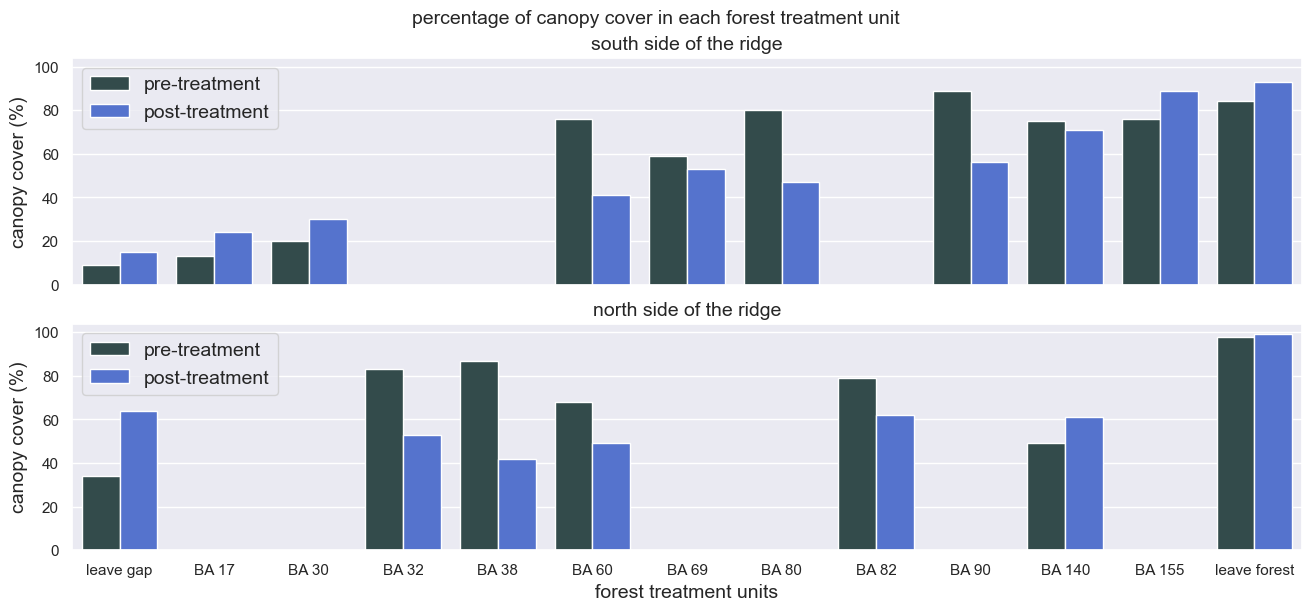

In [25]:

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(13,6), constrained_layout = True)
palette = [colorpre, colorpos]

plt.suptitle('percentage of canopy cover in each forest treatment unit', fontsize=fontsize_num)
fontsize_num = 14

# Create a barplot with values
barplot = sns.barplot(data= df_tidy_north, ax=axes[1], x='BAF', y='canopy_cover', hue='treatment', palette=palette)    
barplot = sns.barplot(data= df_tidy_south, ax=axes[0], x='BAF', y='canopy_cover', hue='treatment', palette=palette)

# # Add values on top of each bar
# for p in barplot.patches:
#     height = p.get_height()
#     plt.text(p.get_x()+p.get_width()/2., 
#              height + 0.1, 
#              '{:1.0f}'.format(height), 
#              ha="center")

# Customize the layout
axes[0].set_xlabel('')
axes[1].set_xlabel('forest treatment units', fontsize=fontsize_num)
axes[0].set_ylabel('canopy cover (%)', fontsize=fontsize_num)
axes[1].set_ylabel('canopy cover (%)', fontsize=fontsize_num)
axes[0].legend(loc='upper left', fontsize=fontsize_num)
axes[1].legend(loc='upper left', fontsize=fontsize_num)

axes[1].set_title('north side of the ridge', fontsize=fontsize_num)
axes[0].set_title('south side of the ridge', fontsize=fontsize_num)

# increase the size of the xtick labels
# axes[0].set_xticks(fontsize=fontsize_num)

# # change the ylabel to be on the right side of the figure instead 
# axes[0].set_yticks(fontsize=fontsize_num)
# plt.gca().yaxis.set_label_position("right")
# plt.gca().yaxis.tick_right()

# export the figure with high resolution
figure_name = 'canopy_cover_side_of_ridge_two.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

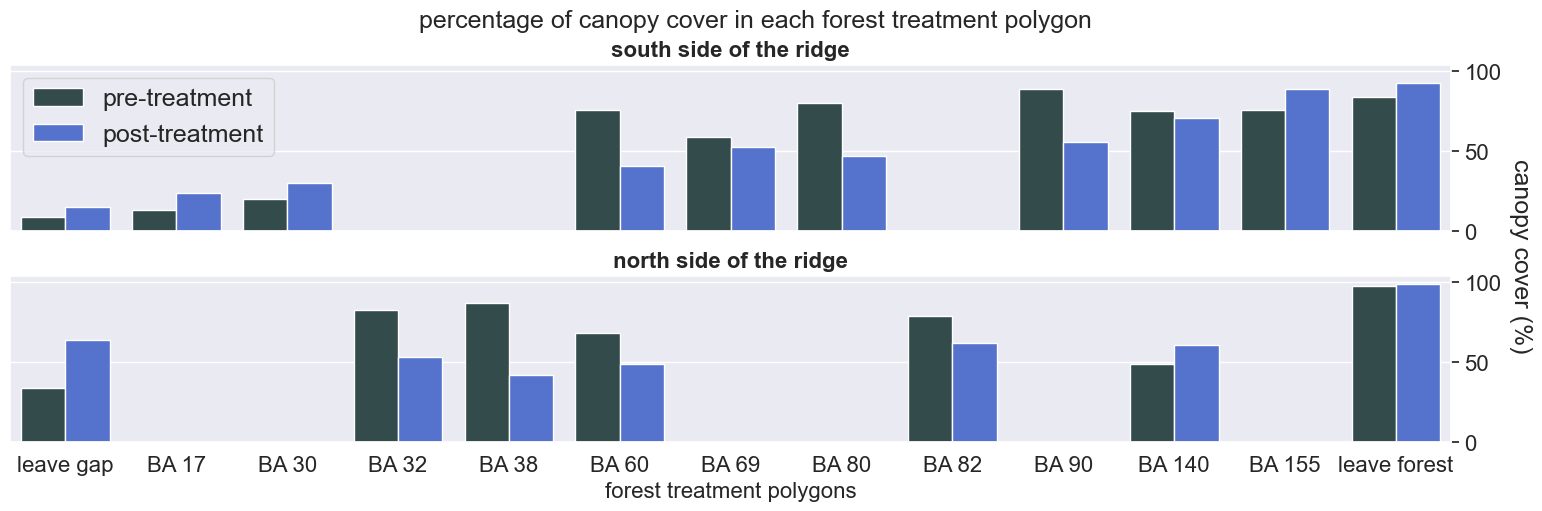

In [26]:

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(15,5), constrained_layout = True)
palette = [colorpre, colorpos]

plt.suptitle('percentage of canopy cover in each forest treatment polygon', fontsize=18)
fontsize_num = 16

# Create a barplot with values
barplot = sns.barplot(data= df_tidy_north, ax=axes[1], x='BAF', y='canopy_cover', hue='treatment', palette=palette)    
barplot = sns.barplot(data= df_tidy_south, ax=axes[0], x='BAF', y='canopy_cover', hue='treatment', palette=palette)

# # Add values on top of each bar
# for p in barplot.patches:
#     height = p.get_height()
#     plt.text(p.get_x()+p.get_width()/2., 
#              height + 0.1, 
#              '{:1.0f}'.format(height), 
#              ha="center")

# Customize the layout
axes[0].set_xlabel('')
axes[1].set_xlabel('forest treatment polygons', fontsize=fontsize_num)
# axes[0].set_ylabel('canopy cover (%)', fontsize=fontsize_num)
# axes[1].set_ylabel('canopy cover (%)', fontsize=fontsize_num)

axes[0].set_ylabel('')
axes[1].set_ylabel('')

# Move the y-axis to the right side
for ax in axes:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
# make a single y-axies label centered between the two subplots 
fig.text(1.01, 0.5, 'canopy cover (%)', ha='center', va='center', rotation=270, fontsize=18)

axes[0].legend(fontsize=18)
# do not show the legend in the second subplot
axes[1].legend().set_visible(False)
# axes[1].legend(fontsize=fontsize_num)

axes[0].set_title('south side of the ridge', fontsize=fontsize_num, fontweight='bold')
axes[1].set_title('north side of the ridge', fontsize=fontsize_num, fontweight='bold')

# increase the size of the xtick labels
# axes[0].set_xticks(fontsize=fontsize_num)
axes[0].tick_params(axis='both', which='major', labelsize=16) #width=2)
axes[1].tick_params(axis='both', which='major', labelsize=16) #width=2)

# export the figure with high resolution
figure_name = 'canopy_cover_side_of_ridge_two_small_verticle.png'
plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

### Lastly, we want to make a plot of canopy cover colored by percentage coverage groups...

In [27]:
# but, we do not want the pre-treatment so let's drop those for the following plots 
df_tidy_south_post = df_tidy_south.where(df_tidy_south['treatment'] == 'post-treatment').dropna(how='all')
df_tidy_north_post = df_tidy_north.where(df_tidy_north['treatment'] == 'post-treatment').dropna(how='all')
df_tidy_north_post

,BAF,treatment,canopy_cover
26,leave gap,post-treatment,64.0
27,BA 17,post-treatment,NaN
28,BA 30,post-treatment,NaN
29,BA 32,post-treatment,53.0
30,BA 38,post-treatment,42.0
31,BA 60,post-treatment,49.0
32,BA 69,post-treatment,NaN
33,BA 80,post-treatment,NaN
34,BA 82,post-treatment,62.0
35,BA 90,post-treatment,NaN


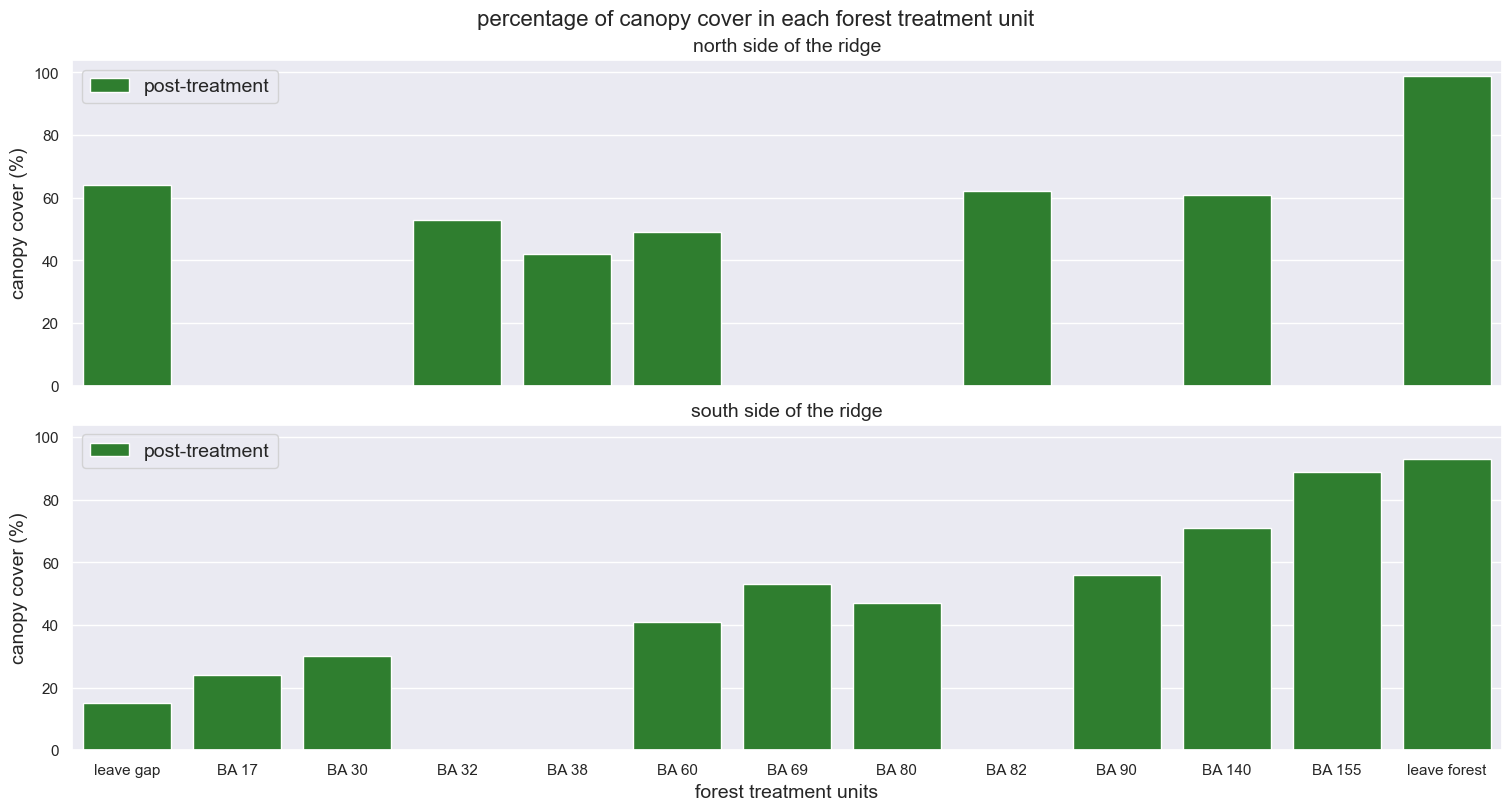

In [28]:

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(15,8), constrained_layout = True)
palette = ['forestgreen']

plt.suptitle('percentage of canopy cover in each forest treatment unit', fontsize=fontsize_num)
fontsize_num = 14

# Create a barplot with values
barplot = sns.barplot(data= df_tidy_north_post, ax=axes[0], x='BAF', y='canopy_cover', hue='treatment', palette=palette)    
barplot = sns.barplot(data= df_tidy_south_post, ax=axes[1], x='BAF', y='canopy_cover', hue='treatment', palette=palette)

# # Add values on top of each bar
# for p in barplot.patches:
#     height = p.get_height()
#     plt.text(p.get_x()+p.get_width()/2., 
#              height + 0.1, 
#              '{:1.0f}'.format(height), 
#              ha="center")

# Customize the layout
axes[0].set_xlabel('')
axes[1].set_xlabel('forest treatment units', fontsize=fontsize_num)
axes[0].set_ylabel('canopy cover (%)', fontsize=fontsize_num)
axes[1].set_ylabel('canopy cover (%)', fontsize=fontsize_num)
axes[0].legend(loc='upper left', fontsize=fontsize_num)
axes[1].legend(loc='upper left', fontsize=fontsize_num)

axes[0].set_title('north side of the ridge', fontsize=fontsize_num)
axes[1].set_title('south side of the ridge', fontsize=fontsize_num)

# ax.patches[0].set_facecolor('limegreen')

# increase the size of the xtick labels
# axes[0].set_xticks(fontsize=fontsize_num)

# export the figure with high resolution
# figure_name = 'canopy_cover_side_of_ridge_two_small.png'
# plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

IndexError: list index out of range

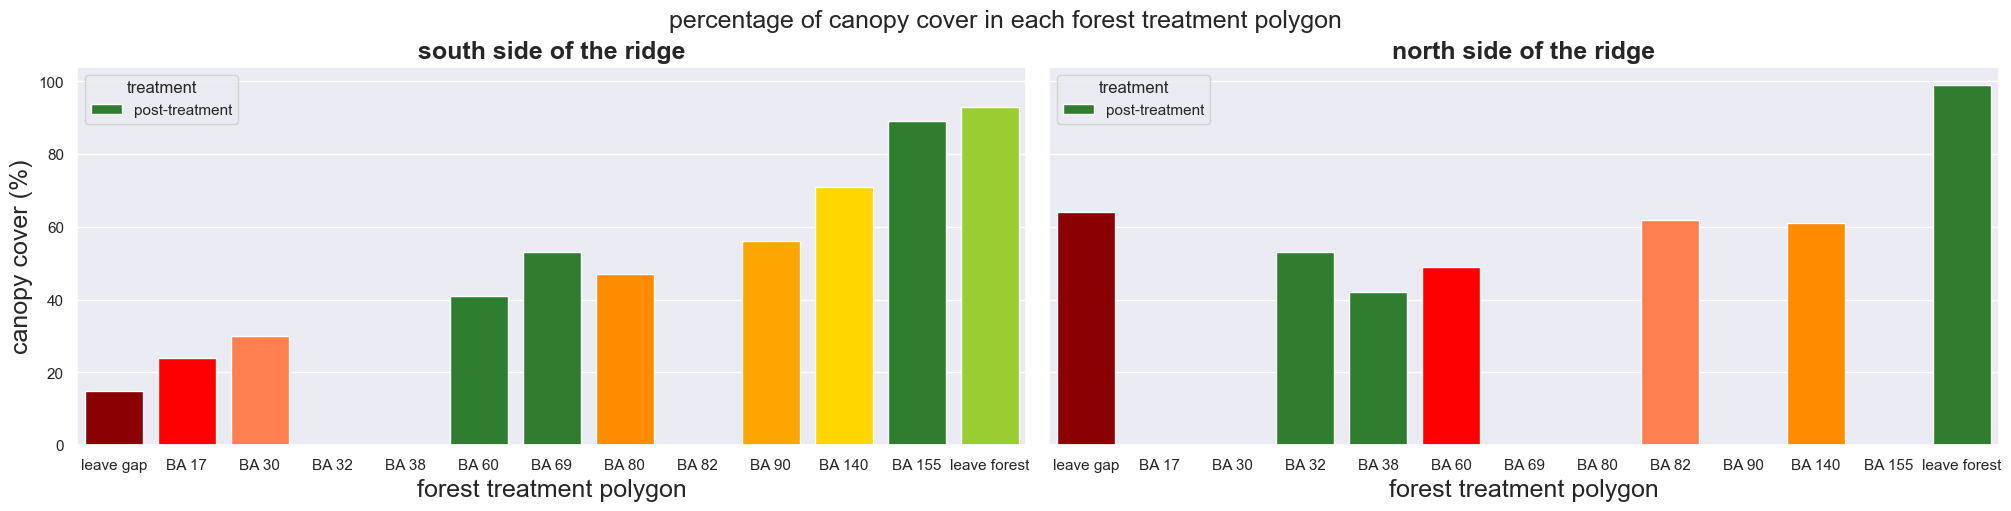

In [31]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,5), constrained_layout = True)

fontsize_num = 18
plt.suptitle('percentage of canopy cover in each forest treatment polygon', fontsize=fontsize_num)

# Create a barplot with values
barplot = sns.barplot(data= df_tidy_north_post, ax=axes[1], x='BAF', y='canopy_cover', hue='treatment', palette=palette)    
barplot = sns.barplot(data= df_tidy_south_post, ax=axes[0], x='BAF', y='canopy_cover', hue='treatment', palette=palette)

# Customize the layout
# axes[0].set_xlabel('')
axes[0].set_xlabel('forest treatment polygon', fontsize=fontsize_num)
axes[1].set_xlabel('forest treatment polygon', fontsize=fontsize_num)
axes[0].set_ylabel('canopy cover (%)', fontsize=fontsize_num)
axes[1].set_ylabel('', fontsize=fontsize_num)

axes[1].set_title('north side of the ridge', fontsize=fontsize_num, fontweight='bold')
axes[0].set_title('south side of the ridge', fontsize=fontsize_num, fontweight='bold')

# color the boxes to match the cdf figure 
axes[0].patches[0].set_facecolor('darkred') # leave gap
axes[0].patches[1].set_facecolor('red') # BA 17
axes[0].patches[2].set_facecolor('coral') # BA 30
# axes[0].patches[3].set_facecolor('green') # BA 32, nothing
# axes[0].patches[4].set_facecolor('orange') # BA 38, nothing
axes[0].patches[5].set_facecolor('darkorange') # BA 60
axes[0].patches[6].set_facecolor('orange') # BA 69
axes[0].patches[7].set_facecolor('gold') # BA80
# axes[0].patches[8].set_facecolor('purple') # BA82 nothing
axes[0].patches[9].set_facecolor('yellowgreen') # BA90
axes[0].patches[10].set_facecolor('darkkhaki') # BA140
axes[0].patches[11].set_facecolor('olive') # BA155
axes[0].patches[12].set_facecolor('darkgreen') # leave forest 


axes[1].patches[0].set_facecolor('darkred') # leave gap
# axes[1].patches[1].set_facecolor('red') # BA 17, nothing
# axes[1].patches[2].set_facecolor('blue') # BA 30, nothing
axes[1].patches[3].set_facecolor('red') # BA 32
axes[1].patches[4].set_facecolor('coral') # BA 38 
axes[1].patches[5].set_facecolor('darkorange') # BA 60 
# axes[1].patches[6].set_facecolor('cyan') # BA 69 nothing
# axes[1].patches[7].set_facecolor('purple') # BA80 nothing
axes[1].patches[8].set_facecolor('gold') # BA82 
# axes[1].patches[9].set_facecolor('purple') # BA90 nothing
axes[1].patches[10].set_facecolor('darkkhaki') # BA140 
# axes[1].patches[11].set_facecolor('purple') # BA155 nothing
axes[1].patches[12].set_facecolor('darkgreen') # leave forest 


# labels 
axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)

axes[0].tick_params(axis='both', which='major', labelsize=14) #,labelrotation=20) 
axes[1].tick_params(axis='both', which='major', labelsize=14) #,labelrotation=20)

axes[0].set_xticklabels(['leave\ngap', 'BA 17', 'BA 30', 'BA 32', 'BA 38', 'BA 60', 'BA 69', 'BA 80', 'BA 82', 'BA 90', 'BA 140', 'BA 155', 'leave\nforest'])
axes[1].set_xticklabels(['leave\ngap', 'BA 17', 'BA 30', 'BA 32', 'BA 38', 'BA 60', 'BA 69', 'BA 80', 'BA 82', 'BA 90', 'BA 140', 'BA 155', 'leave\nforest'])


# export the figure with high resolution
figure_name = 'canopy_cover_side_of_ridge_two_small_horizontal.png'
plt.savefig(figure_path + figure_name, dpi=500)


plt.show()